# Overview
In this third practical application assignment, your goal is to compare the performance of the classifiers (k-nearest neighbors, logistic regression, decision trees, and support vector machines) you encountered in this section of the program.

## Business Understanding: CRISP-DM Step 1
The data is from a Portuguese banking institution and is a collection of the results of multiple marketing campaigns. The objective is to compare model performance against coupon acceptance for predicting if the client will subscribe (yes/no) a term deposit (variable y).

## Data Understanding: CRISP-DM Step 2
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.
here are four datasets: 
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010)
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs)
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs)
For the purposes of this analysis the third dataset was used for model building and comparing.

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from statsmodels.tsa import arima_process
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [57]:
data = pd.read_csv('/Users/benjaminbond/Module17/bank-full.csv',delimiter=';', quotechar='"')

The code below renames the target variable to something more useful than 'y'.

In [60]:
data.rename(columns={'y': 'conversion'}, inplace=True)

In [64]:
data.head(15)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,conversion
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


Total row count: 45,210

## Data Preparation: CRISP-DM Step 3
### Data preparation after our initial exploration

<Axes: title={'center': 'Missing data'}>

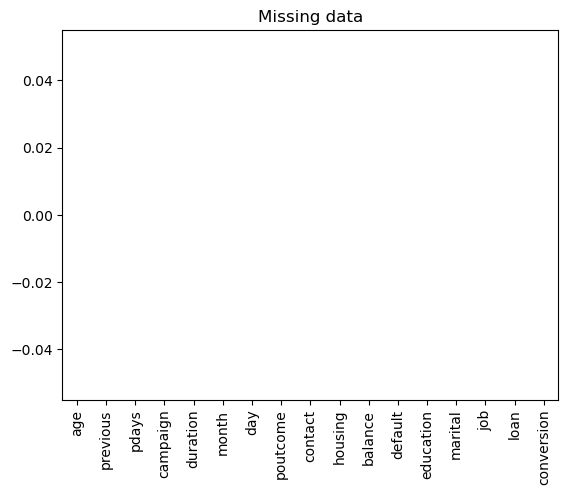

In [66]:
data.isnull().sum().sort_values().plot(kind='bar',title='Missing data')

The plot above shows there are no missing data for any of the dataset features.

In [67]:
# Convert object (categorical) features to integers
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [27]:
# Validate encoder worked as expected
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,conversion
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


Data dictionary provided by https://archive.ics.uci.edu/dataset/222/bank+marketing:

   1 - age 
       (numeric)
   2 - job : type of job 
       (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-
       collar","self-employed","retired","technician","services") 
   3 - marital : marital status 
       (categorical: "married","divorced","single")   note: "divorced" means divorced or widowed)
   4 - education 
       (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? 
       (binary: "yes","no")
   6 - balance: average yearly balance, in euros 
       (numeric) 
   7 - housing: has housing loan? 
       (binary: "yes","no")
   8 - loan: has personal loan? 
       (binary: "yes","no")
related with the last contact of the current campaign:
   9 - contact: contact communication type 
       (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month 
      (numeric)
  11 - month: last contact month of year 
      (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12 - duration: last contact duration, in seconds 
      (numeric)
other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client 
      (numeric, includes last contact)
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign 
      (numeric, -1 means client was not previously contacted)
  15 - previous: number of contacts performed before this campaign and for this client 
      (numeric)
  16 - poutcome: outcome of the previous marketing campaign 
      (categorical: "unknown","other","failure","success")

In [34]:
# Return distinct counts of data in each feature
feature = ['age', 'job', 'marital','education','default','balance','housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome','conversion']

distinct_count = data[feature].nunique()

print("Distinct count of data in feature '{}': {}".format(feature, distinct_count))

Distinct count of data in feature '['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'conversion']': age             77
job             12
marital          3
education        4
default          2
balance       7168
housing          2
loan             2
contact          3
day             31
month           12
duration      1573
campaign        48
pdays          559
previous        41
poutcome         4
conversion       2
dtype: int64


Create a pairplot to see a visualization of the data. In this case, looking for outliers or skewed data.

/Users/benjaminbond/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


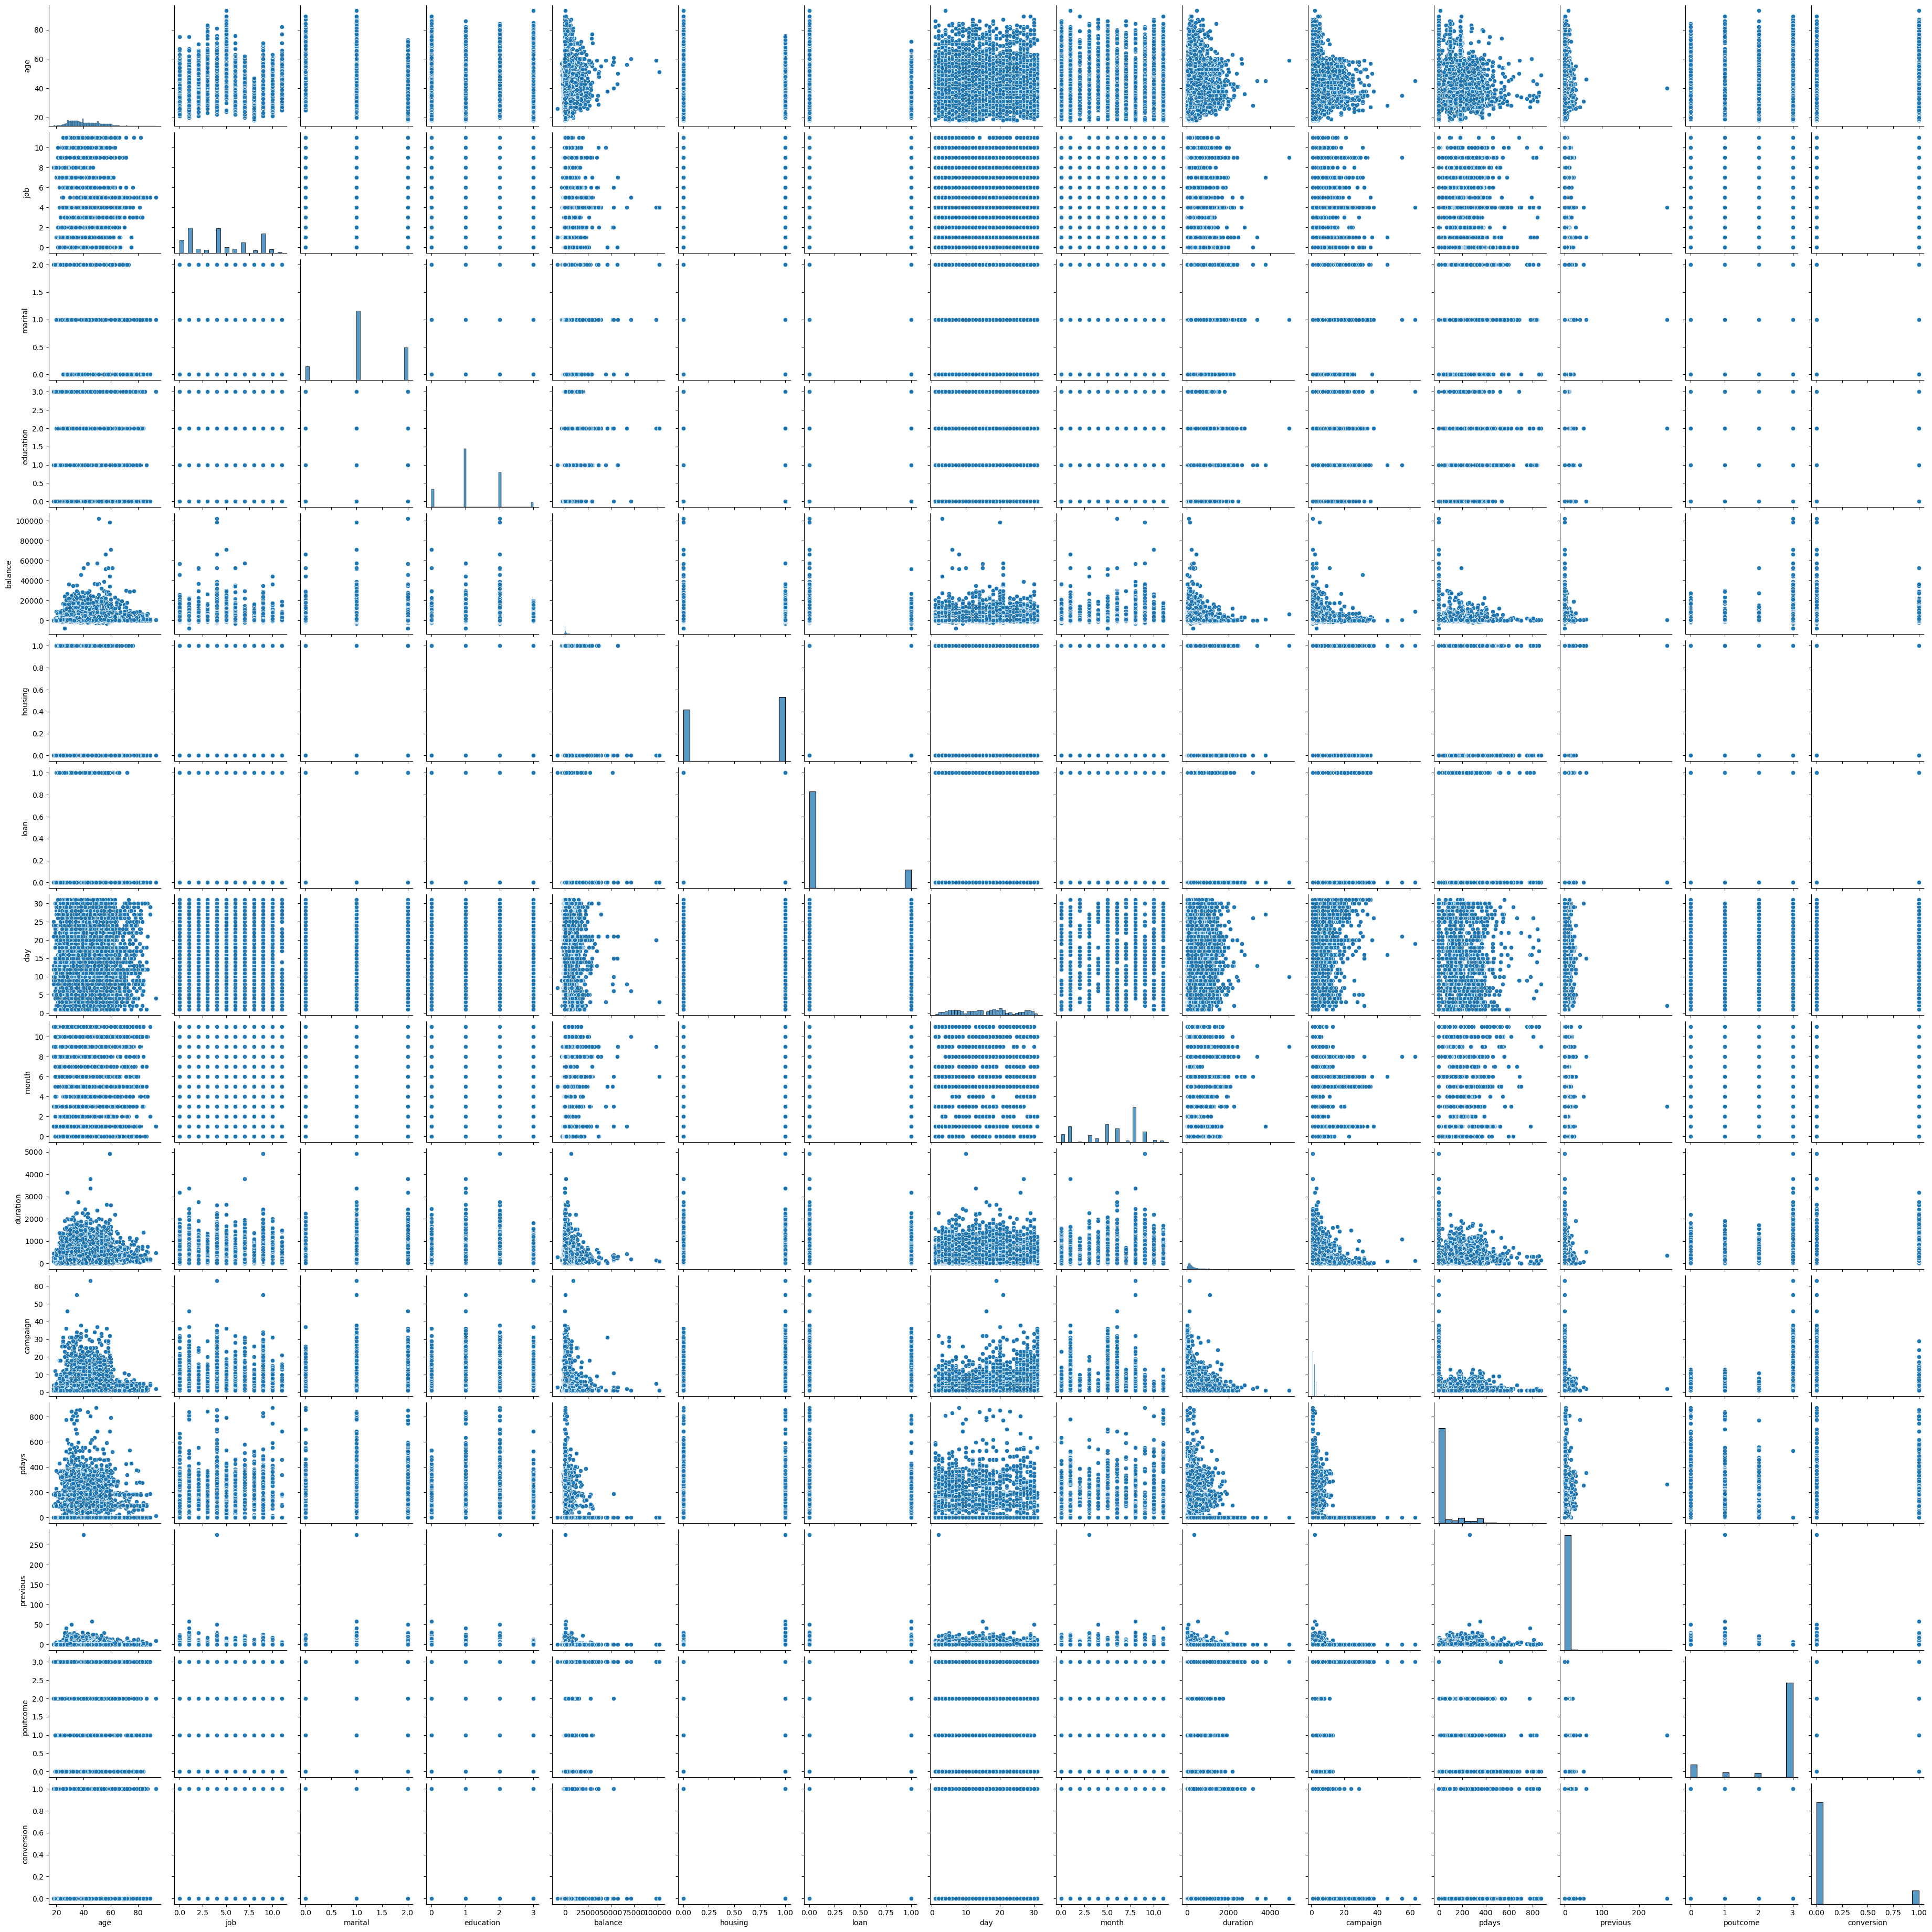

In [28]:
# Sample down the dataset to 20,000 rows
data_sample = data.sample(n=20000, random_state=42)

# Run a pairplot dropping the ID feature
sns.pairplot(data=data_sample, vars=['age', 'job', 'marital','education','balance','housing','loan','day','month','duration','campaign','pdays','previous','poutcome','conversion'])
plt.show()

Investingating the outlier found in the feature 'previous' based on visual validation.

In [39]:
# Find the maximum value for the feature 'previous'
max_previous = data['previous'].max()

# Count the number of rows with the maximum value
max_previous_count = data[data['previous'] == max_previous].shape[0]

print(f"The maximum value for 'previous' is: {max_previous}")
print(f"The number of rows with the maximum value for 'previous' is: {max_previous_count}")


The maximum value for 'previous' is: 275
The number of rows with the maximum value for 'previous' is: 1


In [45]:
# Count the occurrences of each unique value in the 'previous' feature, grouped by 'conversion'
previous_conversion_counts = data.groupby(['previous', 'conversion']).size().reset_index(name='counts')

print("Count of each unique value in the 'previous' feature grouped by 'conversion':")
print(previous_conversion_counts)

Count of each unique value in the 'previous' feature grouped by 'conversion':
    previous  conversion  counts
0          0           0   33570
1          0           1    3384
2          1           0    2189
3          1           1     583
4          2           0    1650
..       ...         ...     ...
61        41           0       1
62        51           0       1
63        55           1       1
64        58           1       1
65       275           0       1

[66 rows x 3 columns]


81.7% of the dataset population did not recieve any contact prior to receiving the offer.

## Modeling: CRISP-DM Step 4

Split the data into test and train sets

In [68]:
# Define features and target
X = data.drop('conversion', axis=1)
y = data['conversion']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the feature variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Preprocessing complete.")
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Preprocessing complete.
Training set shape: (31647, 16)
Test set shape: (13564, 16)


Model: kNN

In [69]:
# kNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Evaluation metrics for kNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("kNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("kNN Accuracy:", accuracy_knn)


kNN Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     11977
           1       0.57      0.32      0.41      1587

    accuracy                           0.89     13564
   macro avg       0.74      0.64      0.68     13564
weighted avg       0.87      0.89      0.88     13564

kNN Accuracy: 0.8923621350634031


Model: Decision Tree

In [70]:
# Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Evaluation metrics for Decision Trees
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Decision Tree Accuracy:", accuracy_dt)


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     11977
           1       0.46      0.48      0.47      1587

    accuracy                           0.87     13564
   macro avg       0.69      0.70      0.70     13564
weighted avg       0.88      0.87      0.87     13564

Decision Tree Accuracy: 0.8731200235918608


Model: Logistic regression

In [71]:
# Logistic Regression model
lr = LogisticRegression(random_state=42, max_iter=10000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluation metrics for Logistic Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Logistic Regression Accuracy:", accuracy_lr)


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94     11977
           1       0.59      0.22      0.32      1587

    accuracy                           0.89     13564
   macro avg       0.75      0.60      0.63     13564
weighted avg       0.87      0.89      0.87     13564

Logistic Regression Accuracy: 0.891108817457977


Model: Support vector machine

In [72]:
# SVM model
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Evaluation metrics for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM Accuracy:", accuracy_svm)


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94     11977
           1       0.66      0.26      0.37      1587

    accuracy                           0.90     13564
   macro avg       0.78      0.62      0.66     13564
weighted avg       0.88      0.90      0.88     13564

SVM Accuracy: 0.8975228546151578


## Evaluation: CRISP-DM Step 5

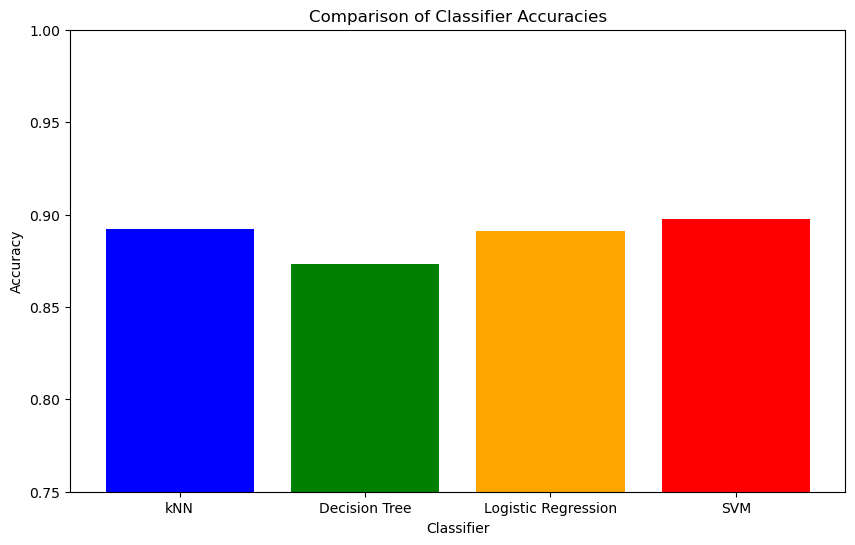

In [78]:
# Collect accuracy scores
model_names = ['kNN', 'Decision Tree', 'Logistic Regression', 'SVM']
accuracies = [accuracy_knn, accuracy_dt, accuracy_lr, accuracy_svm]

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title('Comparison of Classifier Accuracies')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.show()


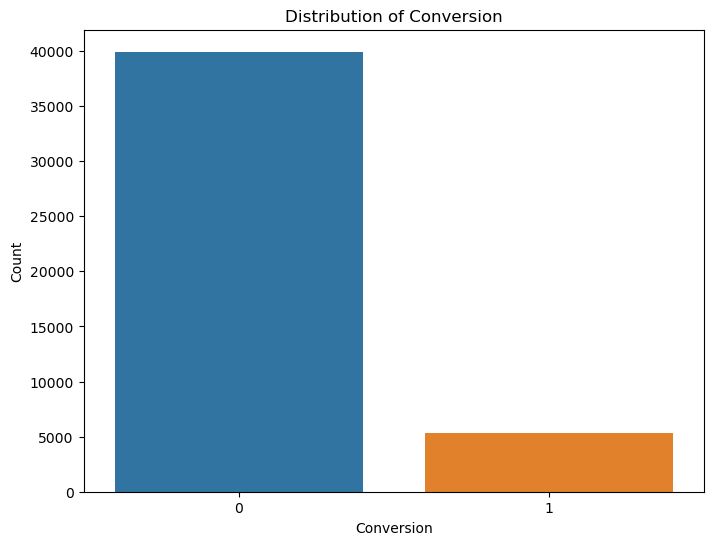

In [84]:
# Plot the distribution of the 'conversion' variable
plt.figure(figsize=(8, 6))
sns.countplot(x='conversion', data=data)
plt.title('Distribution of Conversion')
plt.xlabel('Conversion')
plt.ylabel('Count')
plt.show()


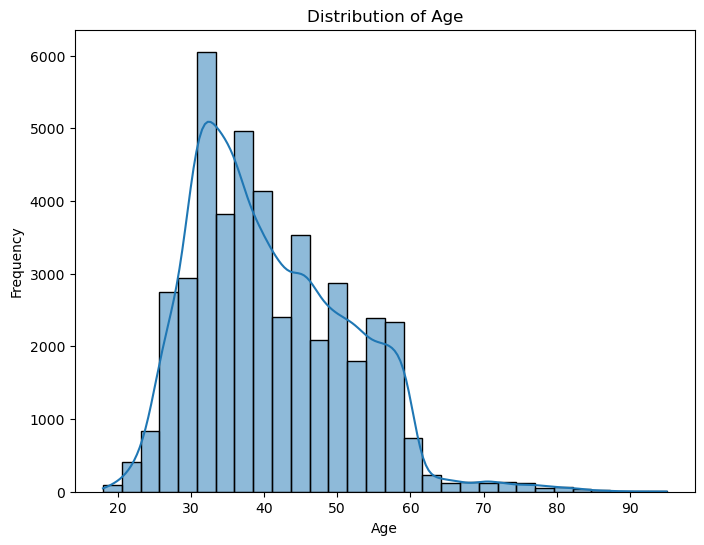

In [75]:
# Plot the distribution of the 'age' variable
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


### Findings, Recommendations and Next Steps

Findings:
    - kNN: Moderate performance with an accuracy of: 0.8923621350634031
    - Decision Tree: Strong performance with an accuracy of: 0.8731200235918608
    - Logistic Regression: Consistent performance with an accuracy of: 0.891108817457977
    - SVM: High performance with an accuracy of: 0.8975228546151578 

Recommendations:
    - Consider using Decision Trees or SVM for future modeling dut to their higher accuacy and robustness
    - Further tune hyperpatameters for potentially better performance
    - Integrate feature engineering to enhance model accuracy

Next Steps:
    - Perform cross-validation to ensure model stability

### Conclusion

The analysis shows that Decision Trees and SVM classifiers provide the best performance for predicting conversion. With proper tuning and potential feature engineering, these models can be further improved to achieve better predictive accuracy. The visualizations and metrics provided clear insights into the data and model performances, making them actionable for business decisions.